In [19]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

In [36]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.utils)

from endoutbreakvbd import eop_analytical
from endoutbreakvbd.chikungunya import get_data, get_parameters, get_weather_data
from endoutbreakvbd.inference import fit_autoregressive_model, fit_suitability_model
from endoutbreakvbd.utils import month_start_xticks

In [21]:
df = get_data()
df_weather = get_weather_data()
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]

rng = np.random.default_rng(2)

In [22]:
doy_start = df["doy"].to_numpy()[0]
incidence_vec = np.append(
    df["cases"].to_numpy(), np.zeros(len(gen_time_dist_vec) + 1, dtype=int)
)
no_days = len(incidence_vec)
t_vec = np.arange(no_days)
doy_vec = (np.arange(doy_start, doy_start + no_days) - 1) % 365 + 1
temperature_vec = (
    df_weather["temperature"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
temperature_vec_smoothed = (
    df_weather["temperature_smoothed"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
suitability_vec = (
    df_weather["suitability"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
suitability_vec_smoothed = (
    df_weather["suitability_smoothed"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)

In [41]:
def plot_data_and_twin(ax):
    ax.bar(df.doy, df["cases"], color="gray", alpha=0.5)
    ax.set_ylim(0, 16)
    ax.set_ylabel("Number of cases")
    twin_ax = ax.twinx()
    return twin_ax


def make_plots(idata_list, model_name_list, color_list):
    _, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 4), constrained_layout=True)
    twin_axs = [plot_data_and_twin(ax) for ax in axs]
    for idata, model_name, color in zip(
        idata_list, model_name_list, color_list, strict=True
    ):
        rep_no_mat = az.extract(idata, var_names="rep_no_vec").to_numpy()
        rep_no_mean_vec = rep_no_mat.mean(axis=1)
        rep_no_lower_vec = np.percentile(rep_no_mat, 2.5, axis=1)
        rep_no_upper_vec = np.percentile(rep_no_mat, 97.5, axis=1)
        rep_no_func_estim = scipy.interpolate.interp1d(
            t_vec, rep_no_mat, axis=0, bounds_error=True
        )
        eop_vec = eop_analytical(
            incidence_vec=incidence_vec,
            rep_no_func=rep_no_func_estim,
            gen_time_dist_vec=gen_time_dist_vec,
            t_calc=t_vec,
        )
        twin_axs[0].plot(
            doy_vec,
            rep_no_mean_vec,
            color=color,
            label=model_name,
        )
        twin_axs[0].fill_between(
            doy_vec,
            rep_no_lower_vec,
            rep_no_upper_vec,
            color=color,
            alpha=0.3,
        )
        twin_axs[1].plot(
            doy_vec,
            1 - eop_vec,
            color=color,
            label=model_name,
        )
    month_start_xticks(axs[0], interval_months=1)
    twin_axs[0].set_ylim(0, 8)
    twin_axs[0].set_ylabel("Time-dependent reproduction number")
    twin_axs[0].legend()
    month_start_xticks(axs[1], interval_months=1)
    twin_axs[1].set_ylim(0, 1)
    twin_axs[1].set_ylabel("Risk of additional cases")

In [24]:
idata_ar = fit_autoregressive_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_rep_no_vec]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [37]:
idata_suitability = fit_suitability_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    suitability_mean_vec=suitability_vec_smoothed,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_rep_no_factor_vec, suitability_ext]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


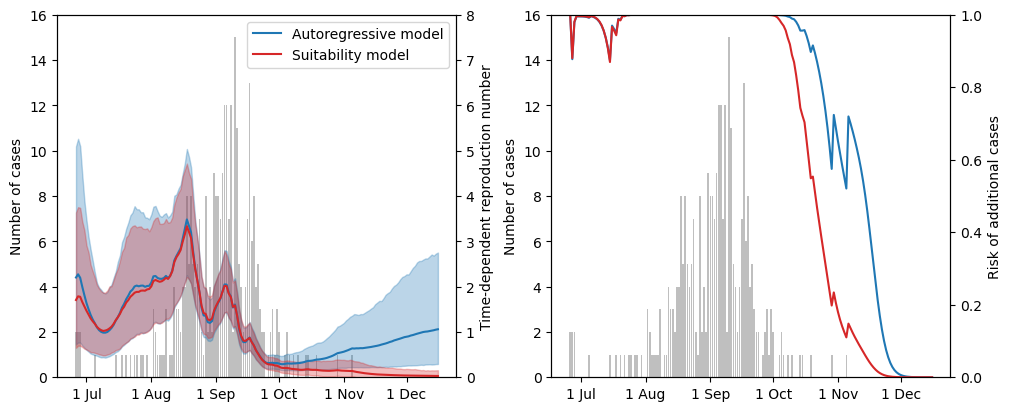

In [43]:
make_plots(
    [idata_ar, idata_suitability],
    ["Autoregressive model", "Suitability model"],
    ["tab:blue", "tab:red"],
)

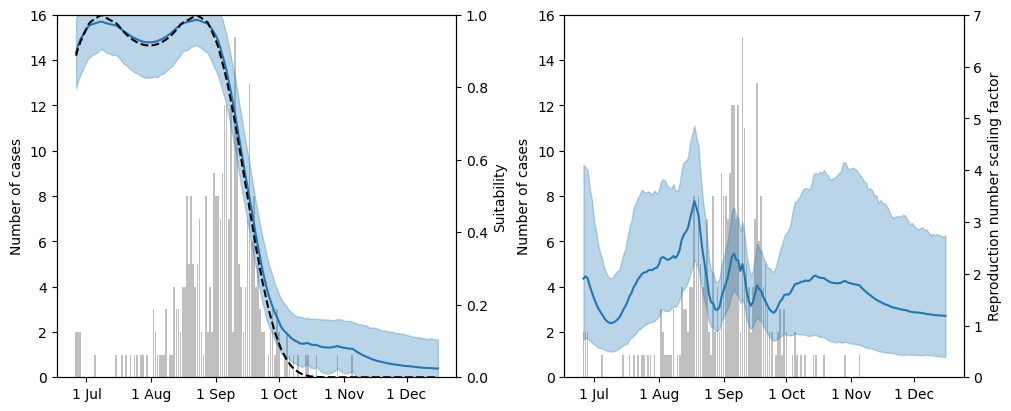

In [40]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 4), constrained_layout=True)
twin_axs = [plot_data_and_twin(ax) for ax in axs]
twin_axs[0].plot(
    doy_vec,
    idata_suitability.posterior["suitability_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
twin_axs[0].fill_between(
    doy_vec,
    np.percentile(
        idata_suitability.posterior["suitability_vec"].values, 2.5, axis=(0, 1)
    ),
    np.percentile(
        idata_suitability.posterior["suitability_vec"].values, 97.5, axis=(0, 1)
    ),
    color="tab:blue",
    alpha=0.3,
)
twin_axs[0].plot(
    doy_vec,
    suitability_vec_smoothed,
    color="black",
    linestyle="dashed",
)
twin_axs[1].plot(
    doy_vec,
    idata_suitability.posterior["rep_no_factor_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
twin_axs[1].fill_between(
    doy_vec,
    np.percentile(
        idata_suitability.posterior["rep_no_factor_vec"].values, 2.5, axis=(0, 1)
    ),
    np.percentile(
        idata_suitability.posterior["rep_no_factor_vec"].values, 97.5, axis=(0, 1)
    ),
    color="tab:blue",
    alpha=0.3,
)
month_start_xticks(axs[0], interval_months=1)
twin_axs[0].set_ylim(0, 1)
twin_axs[0].set_ylabel("Suitability")
month_start_xticks(axs[1], interval_months=1)
twin_axs[1].set_ylim(0, 7)
twin_axs[1].set_ylabel("Reproduction number scaling factor");